# **Competición Redes Neuronales**

### **Instalación de dependencias**

In [1]:
# pip install numpy matplotlib torch scikit-learn pandas

### **Importar librerías**

In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
semilla = 42
np.random.seed(semilla)
torch.manual_seed(semilla)
torch.cuda.manual_seed_all(semilla)
random.seed(semilla)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **Carga y lectura de datos de entrenamiento**

#### Al presentar un formato de archivo NPZ, contenedor comprimido que almacena arrglos de NumPy, es necesario ver cuantos archivos existen por medio de sus claves de identificación

In [4]:
x = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/X_train.npz')
y = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/Y_train.npz')
print(x)
print(y)

NpzFile '/Users/miguelflores/Desktop/Redes-Neuronales/data/X_train.npz' with keys: X_tr
NpzFile '/Users/miguelflores/Desktop/Redes-Neuronales/data/Y_train.npz' with keys: Y_tr


In [5]:
# Visualizar las claves
print('Clave de x_train:', x.files,'Clave de y_train:',  y.files)

Clave de x_train: ['X_tr'] Clave de y_train: ['Y_tr']


### **Dimensión**

In [6]:
x = x['X_tr']
y = y['Y_tr']
x.shape, y.shape

((35000, 784), (35000,))

#### En 'x', presentamos 35,000 observaciones con 784 características, las cuales son provenientes del aplanado de imagenes con dimensiones (28x28). En 'y' son las etiquetas que estan asociadas a cada una de las observaciones de x_train.

### **Tipo de datos**

In [7]:
x.dtype, y.dtype

(dtype('float32'), dtype('int64'))

#### Rectificamos el tipo de datos para cada archivo, donde las imágenes deben ser de tipo float, ya que esto permite calcular gradientes y realizar predicciones. Además, se representan como matrices de píxeles que pueden tener valores entre 0 y 255 (escala de grises) o entre 0 y 1 cuando están normalizadas. Las etiquetas deben ser de tipo entero, ya que representan clases, lo que facilita la estimación de las funciones de coste.

### **Contenido de las variables**

In [8]:
# Imagenes
minimo = np.min(x)
maximo = np.max(x)
print(f'Valores de las imagenes:')
print(f'Mínimo: {minimo}, Máximo: {maximo}')

Valores de las imagenes:
Mínimo: 0.0, Máximo: 0.99609375


In [9]:
# Etiquetas
numero_clases = len(np.unique(y))
print(f"El número de clases en el dataset es: {numero_clases}")
np.unique(y)


El número de clases en el dataset es: 2


array([0, 1])

#### Determinamos que las imágenes ya están normalizadas, ya que presentan valores entre 0 y 1. Por lo tanto, no es necesario dividirlas entre 255 (valor máximo en escala de grises). Además, las etiquetas representan dos clases, lo que confirma que se trata de un problema de clasificación binaria.

# **Inicialización**

### **Preparación de datos: División en entrenamiento y validación**

In [10]:
porcentaje_train = 0.1  #10% de validacion

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = porcentaje_train, random_state = semilla)

#### *Rectificamos división*

In [11]:
# Verificar las dimensiones
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

X_train shape: (31500, 784), y_train shape: (31500,)
X_valid shape: (3500, 784), y_valid shape: (3500,)


### **Cambio de formato**

#### Al corroborar la división en entrenamiento y validación de ambas bases de datos, es posible visualizar que las imagenes siguen presentando un formato aplanado, por lo que para ser apatas para emplearse en una red neuronal convolucional, es necesario sustituirlas a una dimensión donde se presente el número de imagenes por lote, el canal de la imagen, la altura y el ancho. (N,C,H,W).

In [12]:
# Reformatear x_train y x_valid
x_train = torch.from_numpy(x_train).view(-1, 1, 28, 28).to('mps')  # (N, 1, 28, 28)
x_valid = torch.from_numpy(x_valid).view(-1, 1, 28, 28).to('mps')  # (N, 1, 28, 28)

#### Inicialmente presentamos el número de imagenes por lote (-1), donde se situa un valor negativo debido a que nos ayuda a determinar de manera automática el tamaño del lote con base en el número total de elementos del tensor. Después se presenta la dimensión de las imágenes, siendo de 28 x 28, lo cual significa que la imagen es una matriz bidimensional en la que cada entrada representa la intensidad de un píxel. Esto implica que, al haber un solo valor por píxel, la imagen es en escala de grises (1 canal), ya que cada píxel tiene un único valor que define su intensidad (brillo u oscuridad). Además, no hay información adicional de color ni transparencia.

### **Especificamos parámetros de la red**

In [13]:
epoch = 15
batch = 32
aprendizaje = [0.001, 0.01, 0.1]
momentums = [0.8, 0.9, 0.99]
dropout = 0.5

### **TensorDate**

In [14]:
tensor_train = TensorDataset(x_train, torch.from_numpy(y_train).to('mps'))
tensor_valid = TensorDataset(x_valid, torch.from_numpy(y_valid).to('mps'))

### **Dataloaders**

In [15]:
train_loader = DataLoader(tensor_train, batch_size = batch, shuffle=True)  # Para entrenamiento
valid_loader = DataLoader(tensor_valid, batch_size = batch, shuffle=False)  # Para validación

### **Pesos**

In [16]:
w1 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 1)), (32, 1, 3, 3)).astype('float32')).to('mps').requires_grad_()
w2 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 32)), (64, 32, 3, 3)).astype('float32')).to('mps').requires_grad_()
w_dense = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / 36864), (36864, 1)).astype('float32')).to('mps').requires_grad_()

### **Sesgos**

In [17]:
b1 = torch.zeros((32,), dtype=torch.float32).to('mps').requires_grad_()
b2 = torch.zeros((64,), dtype=torch.float32).to('mps').requires_grad_()
b_dense = torch.zeros((1,), dtype=torch.float32).to('mps').requires_grad_()

### **Parametros**

In [18]:
parametros = [w1, b1, w2, b2, w_dense, b_dense]

# **Forward**

### **Funciones**

In [19]:
# Funcion de activación
def activation(x, func):
    if func == "relu":
        return F.relu(x)
    elif func == "sigmoid":
        return torch.sigmoid(x)
    else:
        raise ValueError("Función de activación no soportada")

# Función de propagación hacia adelante
def forward(x, training = True):
    # Primera convolución
    x = F.conv2d(x, w1, b1, stride = 1, padding = 0)
    x = activation(x, 'relu')
    if training:
        x = F.dropout(x, p = dropout, training = training)  # Aplicar Dropout
    # Segunda convolución
    x = F.conv2d(x, w2, b2, stride = 1, padding = 0)
    x = activation(x, 'relu')
    if training:
        x = F.dropout(x, p = dropout, training = training)  # Aplicar Dropout
    # Flatten
    x = x.view(x.size(0), -1)  # Aplanar a (batch_size, 36864)
    # Capa densa
    logits = x @ w_dense + b_dense
    return logits

# Función de pérdida
def perdida(y_pred, y_true):
    # Asegurar que y_true tenga la misma forma que y_pred
    y_true = y_true.unsqueeze(-1)  # Convertir de (32) a (32, 1)
    return F.binary_cross_entropy_with_logits(y_pred, y_true.float())

# Función de calculo de precisión
def precision(y_pred, y_true):
    y_true = y_true.unsqueeze(-1)  # Asegurar que las dimensiones coincidan
    predictions = (torch.sigmoid(y_pred) > 0.5).int()  # Convertir logits a etiquetas binarias
    accuracy = (predictions == y_true).float().mean().item()  # Comparar y calcular promedio
    return accuracy

### **Bucle de Entrenamiento**

In [21]:
iteracion_sin_mejora = 3  # Número de épocas consecutivas sin mejora para detener el entrenamiento (Early Stopping)

# Inicialización de variables globales para almacenar los mejores resultados
best_hyperparameters = None  # Almacena los hiperparámetros con el mejor resultado
best_validation_accuracy_global = 0.0  # Mejor precisión de validación alcanzada globalmente

# Lista para almacenar los resultados de cada combinación de hiperparámetros
results = []

# Bucle para probar combinaciones de hiperparámetros
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")
        
        # Configurar optimizador con los hiperparámetros actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Inicialización de métricas y contadores
        train_losses, train_accuracies = [], []
        valid_losses, valid_accuracies = [], []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento y validación
        for e in range(epoch):
            train_loss, train_acc = 0.0, 0.0

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view(-1, 1, 28, 28)  # Ajustar dimensiones si es necesario
                y_batch = y_batch.squeeze()  # Quitar dimensiones adicionales si existen

                # Propagación hacia adelante
                y_pred = forward(x_batch, training = True)
                loss = perdida(y_pred, y_batch)
                accuracy = precision(y_pred, y_batch)
                
                # Backpropagation
                loss.backward()
                optimizer.step()  # Actualizar los pesos
                optimizer.zero_grad()  # Resetear gradientes

                train_loss += loss.item()
                train_acc += accuracy

            # Guardar métricas de entrenamiento
            train_losses.append(train_loss / len(train_loader))
            train_accuracies.append(train_acc / len(train_loader))

            # Evaluación en validación
            valid_loss, valid_acc = 0.0, 0.0
            for x_val, y_val in valid_loader:
                x_val = x_val.view(-1, 1, 28, 28)  # Ajustar dimensiones si es necesario
                y_val = y_val.squeeze()  # Quitar dimensiones adicionales si existen

                y_pred = forward(x_val, training=False)
                valid_loss += perdida(y_pred, y_val).item()
                valid_acc += precision(y_pred, y_val)

            valid_losses.append(valid_loss / len(valid_loader))
            valid_accuracies.append(valid_acc / len(valid_loader))

            print(f"Epoch {e + 1}/{epoch} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
                  f"Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.4f}")

            # Guardar resultados en el diccionario
            results.append({
                "learning_rate": lr,
                "momentum": mm,
                "epoch": e + 1,
                "train_loss": train_losses[-1],
                "train_accuracy": train_accuracies[-1],
                "valid_loss": valid_losses[-1],
                "valid_accuracy": valid_accuracies[-1]
            })

            # Early Stopping
            if valid_accuracies[-1] > best_validation_accuracy:
                best_validation_accuracy = valid_accuracies[-1]
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= iteracion_sin_mejora:
                print("*** Early Stopping ***")
                break

        # Guardar los mejores hiperparámetros globales
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = {'learning_rate': lr, 'momentum': mm}

# Resultado final
if best_hyperparameters:
    print(f"\nMejores Hiperparámetros: {best_hyperparameters}, Precisión de Validación: {best_validation_accuracy_global:.4f}")
else:
    print("No se encontró ninguna combinación con mejora.")



------- Probando combinación: learning_rate=0.001, momentum=0.8 -------
Epoch 1/15 - Train Loss: 0.3173, Train Acc: 0.8645, Valid Loss: 0.3192, Valid Acc: 0.8532
Epoch 2/15 - Train Loss: 0.2086, Train Acc: 0.9188, Valid Loss: 0.1951, Valid Acc: 0.9349
Epoch 3/15 - Train Loss: 0.1675, Train Acc: 0.9363, Valid Loss: 0.2095, Valid Acc: 0.9202
Epoch 4/15 - Train Loss: 0.1498, Train Acc: 0.9444, Valid Loss: 0.1849, Valid Acc: 0.9281
Epoch 5/15 - Train Loss: 0.1358, Train Acc: 0.9494, Valid Loss: 0.1622, Valid Acc: 0.9446
Epoch 6/15 - Train Loss: 0.1267, Train Acc: 0.9534, Valid Loss: 0.1479, Valid Acc: 0.9506
Epoch 7/15 - Train Loss: 0.1185, Train Acc: 0.9565, Valid Loss: 0.1310, Valid Acc: 0.9577
Epoch 8/15 - Train Loss: 0.1136, Train Acc: 0.9592, Valid Loss: 0.1426, Valid Acc: 0.9548
Epoch 9/15 - Train Loss: 0.1085, Train Acc: 0.9614, Valid Loss: 0.1317, Valid Acc: 0.9554
Epoch 10/15 - Train Loss: 0.1056, Train Acc: 0.9615, Valid Loss: 0.1149, Valid Acc: 0.9645
Epoch 11/15 - Train Loss: 

### **Gráficos**

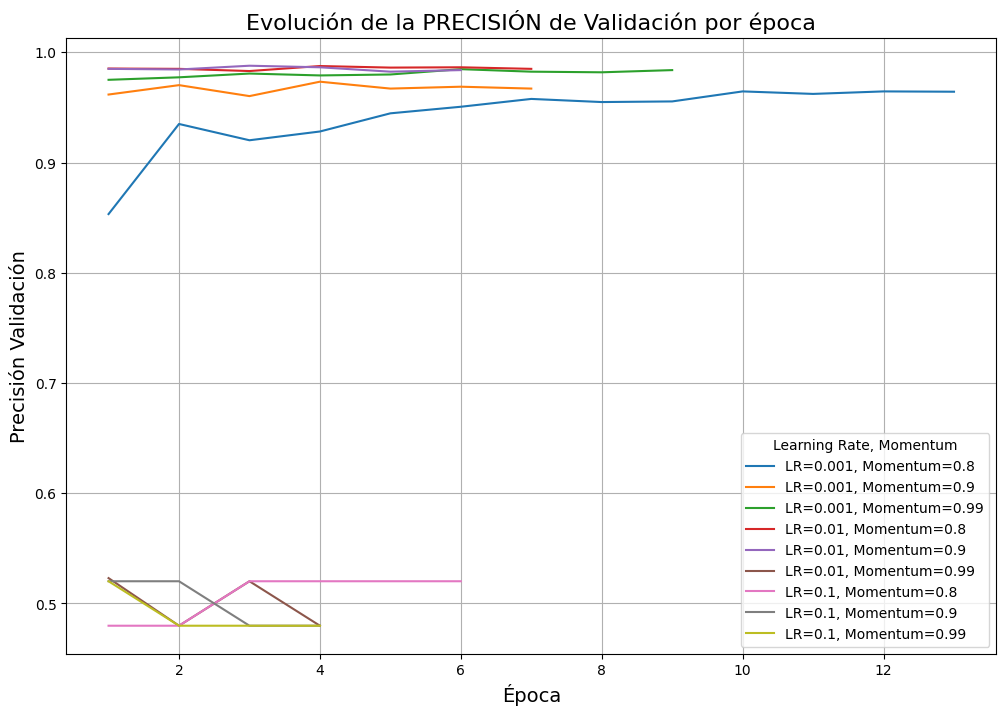

In [23]:
df = pd.DataFrame(results)

# Filtrar los datos para cada combinación de learning_rate y momentum
combinations = df.groupby(['learning_rate', 'momentum'])

# Graficar la evolución de "valid_accuracy" por epoch para cada combinación
plt.figure(figsize=(12, 8))
for (lr, mm), group in combinations:
    plt.plot(group['epoch'], group['valid_accuracy'], label=f'LR={lr}, Momentum={mm}')

plt.title('Evolución de la PRECISIÓN de Validación por época', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Precisión Validación', fontsize=14)
plt.legend(title="Learning Rate, Momentum", fontsize=10)
plt.grid(True)
plt.show()


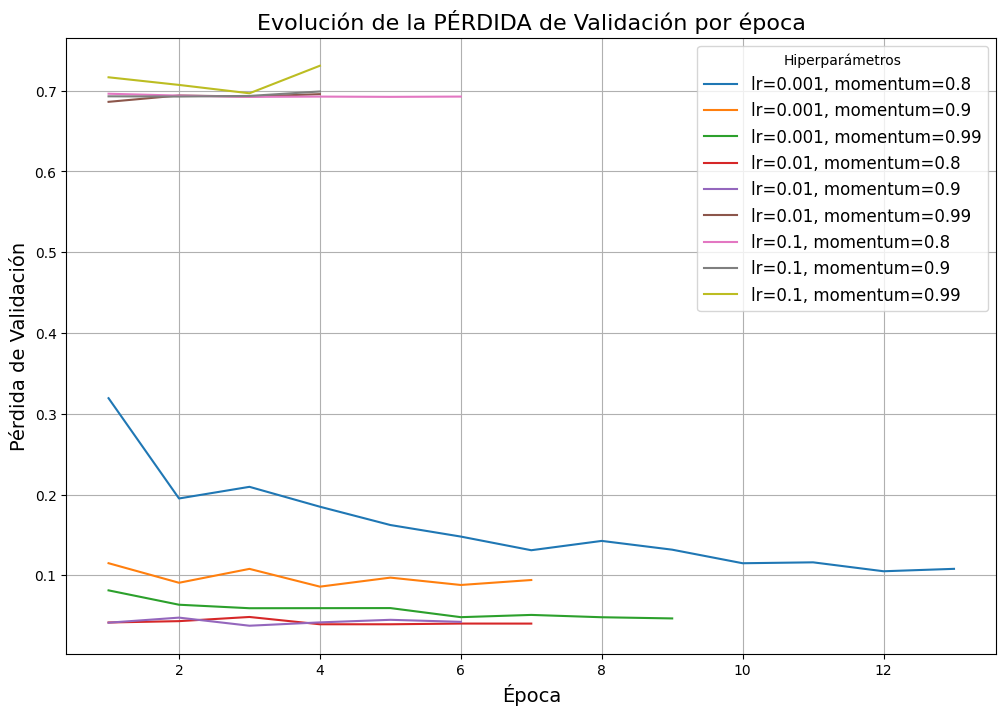

In [24]:
# Configurar el gráfico de evolución de la pérdida de validación
plt.figure(figsize=(12, 8))

# Generar el gráfico
for (lr, mm), data in df.groupby(['learning_rate', 'momentum']):
    plt.plot(data['epoch'], data['valid_loss'], label=f"lr={lr}, momentum={mm}")

# Configurar etiquetas y título
plt.title('Evolución de la PÉRDIDA de Validación por época', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Pérdida de Validación', fontsize=14)
plt.legend(title='Hiperparámetros', fontsize=12)
plt.grid(True)

# Mostrar el gráfico
plt.show()

### **Función test**

In [25]:
data = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/X_test.npz')
X_te = torch.tensor(data['X_te']).float().to('mps')

In [27]:
# Ajustar forma de X_test (suponiendo imágenes de 28x28 píxeles)
X_test = X_te.view(-1, 1, 28, 28)  # Cambiar forma a [batch_size, channels, height, width]

# Dividir X_test en lotes y realizar predicciones
if best_hyperparameters:
    print(f"\nUsando los mejores hiperparámetros encontrados: Learning Rate={best_hyperparameters['learning_rate']}, Momentum={best_hyperparameters['momentum']}")

    # Configurar el optimizador con los mejores hiperparámetros encontrados
    optimizer = torch.optim.SGD(parametros, lr=best_hyperparameters['learning_rate'], momentum=best_hyperparameters['momentum'])

    # Generar predicciones para el conjunto de test
    Y_te = []  # Lista para almacenar las predicciones
    with torch.no_grad():  # Desactivar cálculo de gradientes
        for i in range(0, len(X_test), batch):  # Procesar por lotes
            x_batch = X_test[i:i + batch]  # Crear lotes
            y_pred = forward(x_batch, training=False)  # Forward sin Dropout
            predictions = (torch.sigmoid(y_pred) > 0.5).int().cpu().numpy()  # Convertir logits a etiquetas binarias
            Y_te.extend(predictions.flatten())  # Agregar predicciones al array

    # Convertir la lista de predicciones a un array unidimensional
    Y_te = np.array(Y_te)

    # Guardar las predicciones en un archivo comprimido
    np.savez_compressed('Y_test', Y_te=Y_te)
    print("Predicciones guardadas en el archivo 'Y_test.npz'.")
else:
    print("No se encontraron hiperparámetros óptimos. No se generarán predicciones.")


Usando los mejores hiperparámetros encontrados: Learning Rate=0.01, Momentum=0.9
Predicciones guardadas en el archivo 'Y_test.npz'.
